In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import warnings

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [2]:
# down.matplotlib_update_settings()

In [3]:
def extract_sample_data(inputfile, outputfile,
                        clat=34.875, clon=-98.125, c=3, dx=0.25):
    '''------------------------------------------------------------------------
    Extract a given bounding box centered in (clat, clon) with size npix
    grid cells from an input hdf file
    and save it as nc dataset for further analysis
    ------------------------------------------------------------------------'''
    # f = h5py.File(os.path.join(cdat.tmpa_dir, 'data_tmpa_3h.hdf5'), "r")
    f = h5py.File(inputfile, "r")
    # print(list(f.keys()))
    # print(list(f.attrs()))
    tmpalat = f['lat'][:]
    tmpalon = f['lon'][:]
    dates_int = f['dates'][:]
    hours_int = f['hours'][:]
    dset = f['prcp']
    print('dataset shape = {}'.format(dset.shape)) # too large to fit in memory!
    x = da.from_array(dset, chunks=(6, 6, 300))
    # UTC time
    dates = [datetime.strptime(str(integd)+str(inthour), '%Y%m%d%H')
                    for integd, inthour in zip(dates_int, hours_int)]
    # create xarray
    xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
    # set negative values to NaN (missing values)
    xrs = xrs0.where(xrs0 >= -0.001)
    # now extract a bounding box of interest:
    # clat = 34.875
    # clon = -98.125
    # dx = 0.25
    # npix = 3
    buffer = 0.50*npix*dx
    eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
    # eps = 0 # to make sure to include boundaires -> add an eps buffer
    solat = clat - buffer + eps
    nolat = clat + buffer + eps
    ealon = clon + buffer + eps
    welon = clon - buffer + eps
    bcond = np.logical_and(
                np.logical_and( xrs.lat > solat, xrs.lat < nolat),
                np.logical_and( xrs.lon > welon, xrs.lon < ealon))
    # XARRAY WITH VALUES LOADED IN MEMORY
    box_3h = xrs.where(bcond, drop = True).load()
    print(box_3h.shape)
    box_3h.to_netcdf(outputfile)

In [4]:
extract_box = True # do it only once
# inputfile = os.path.join('..', cdat.tmpa_dir, 'data_tmpa_3h.hdf5')
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, 'data_tmpa_3h.hdf5')
outputdir = os.path.join('..', 'data', 'sample_data')
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
# outputfile = os.path.join('..', 'sample_data','okla.nc')
outputfile = os.path.join(outputdir,'okla.nc')

# ORIGINAL POINT
# clat = 34.875
# clon = -98.125

# TEST ARTURO
dx_2 = 0.125
dy_2 = 0.125
clat = 34.875 - 2*dy_2
clon = -98.125 + dx_2

dx = 0.25
npix = 3
if extract_box:
    extract_sample_data(inputfile, outputfile, clat=clat, clon=clon, npix=npix,dx=dx)

dataset shape = (280, 112, 2433)
(3, 3, 2433)


In [5]:
box_3h = xr.open_dataarray(outputfile)
Tr = 100

res = {}  # initialize dictionary for storing results

In [6]:
DATA = h5py.File(inputfile, "r")
ALL_lat = DATA['lat'][:]
ALL_lon = DATA['lon'][:]
lon2d, lat2d = np.meshgrid(ALL_lon, ALL_lat)
del DATA

lon2d_box, lat2d_box = np.meshgrid(box_3h['lon'], box_3h['lat'])

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


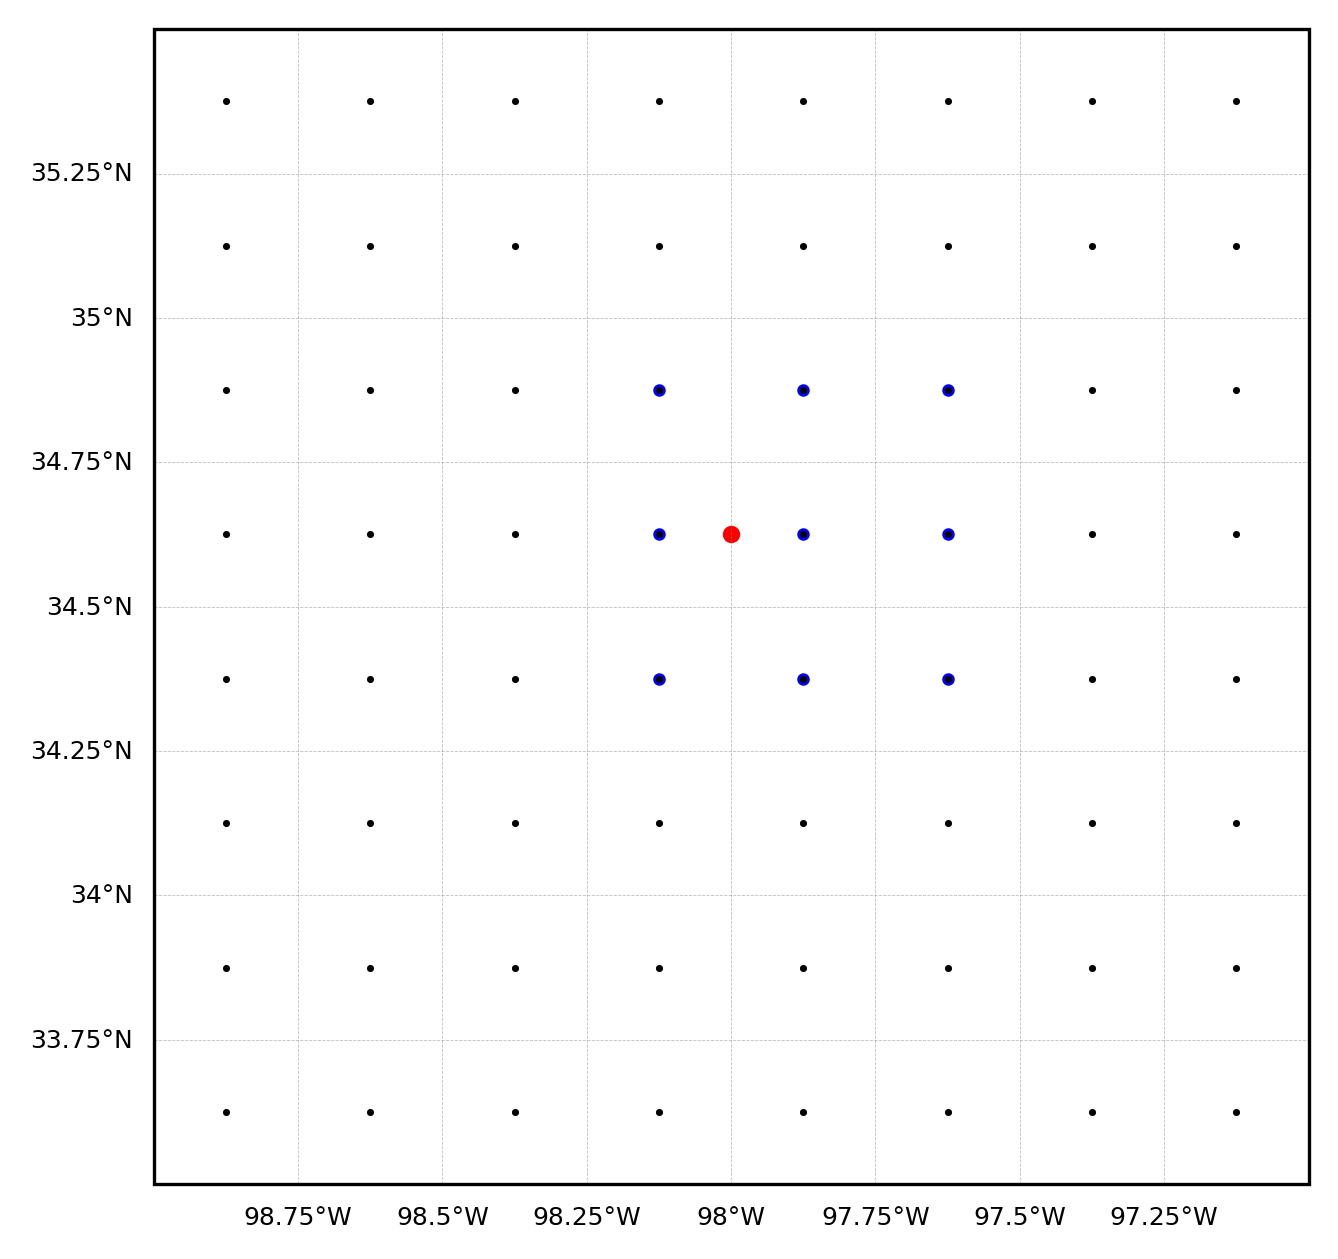

In [8]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')

ax1.set_extent([-99, -97, 33.5, 35.5], crs=proj)

ax1.scatter(clon,clat,s=10, color='r')
ax1.scatter(lon2d_box, lat2d_box,s=4, color='b')
ax1.scatter(lon2d, lat2d ,s=0.5, color='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

In [8]:
# downscaling:
print('Example: running the downscaling function')
init_time = time.time()
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=300, clat=clat, clon=clon,
                            opt_method='genetic', plot=True)#maxmiss=36
end_time = time.time()
exec_time = end_time - init_time
print('Downscaling, execution time was = {} minutes'.format(exec_time/60))

Example: running the downscaling function
Downscaling Intermittency


/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will b

Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.001597120873753757
differential_evolution step 2: f(x)= 0.0014753972066053125
differential_evolution step 3: f(x)= 0.001095144686417439
differential_evolution step 4: f(x)= 0.001095144686417439
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
[79.]
[9.26267262]
[0.6733952]
Downscaling pdf - yearly Weibull parameters
[66.]
[9.25849691]
[0.67310152]
Downscaling, execution time was = 1.7405550718307494 minutes


In [9]:
downres

{'NYs': array([71.]),
 'CYs': array([8.61735632]),
 'WYs': array([0.67038899]),
 'NYd': array([66.]),
 'CYd': array([9.25849691]),
 'WYd': array([0.67310152]),
 'Tr': 100,
 'mev_d': 234.87197833930483,
 'mev_s': 224.2778870382742,
 'gam_d': 0.9374881638730166,
 'gam_s': 0.9548208820769843,
 'beta': 1.0699051519105547,
 'Nd': 79.0,
 'Cd': 9.262672622037506,
 'Wd': 0.6733951983196969,
 'Ns': 85,
 'Cs': 8.617356318882155,
 'Ws': 0.6703889921138572,
 'eps_s': 249.53109745918042,
 'alp_s': 0.8840289366700681,
 'eps_d': 46.34530792229506,
 'alp_d': 0.22973491741628274,
 'corr_down_success': True,
 'corr_down_funval': 0.0009637275856898697,
 'w_down_funval': 3.895106459594899e-12,
 'thresh': 1.0,
 'clat': 35.125,
 'clon': -97.875,
 'corr_plot': <Figure size 640x480 with 1 Axes>,
 'Taylor_contour': <Figure size 640x480 with 2 Axes>}

In [10]:
# down.downscale_pwet(box_3h, thresh=1, dt=3, L1=25,
#                     target_x=0.0001, target_t=24,
#                     origin_x=25, origin_t=24, ninterp=1000, plot=True)

In [11]:
pwets, xscales, tscales = down.compute_pwet_xr(box_3h, 1,cube1size=3, dt=3, tmax=48)
len(pwets), len(xscales), len(tscales)

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will b

(10, 3, 10)

In [12]:
L1=25
target_x=0.001
target_t=24
origin_x=25
origin_t=24
ninterp = 1000,

In [13]:
xscales_km = xscales*L1
ntscales = np.size(tscales)
nxscales = np.size(xscales)
tscales_int = np.linspace(np.min(tscales), np.max(tscales), ninterp[0])
pwmat_int = np.zeros((ninterp[0], nxscales))
for col in range(nxscales):
    pwmat_int[:, col] = np.interp(tscales_int, tscales, pwets[:, col])

In [14]:
# dxv, dtv = np.meshgrid(xscales_km, tscales_int )
pw_min = np.min(pwets)
pw_max = np.max(pwets)
mypw = np.linspace(pw_min, pw_max, ninterp[0])

In [15]:
myU = np.zeros(ninterp[0])   # initialize linear slope
myX0 = np.zeros(ninterp[0])  # initialize linear intercept
myindices = np.zeros((ninterp[0], nxscales), dtype = int)
# tvec =  np.zeros((ninterp, nxscales))

In [16]:
for ii in range(ninterp[0]):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(pwmat_int[:, jj] - mypw[ii]))
        # tvec[ii,jj] = tscales_int[myindices[ii,jj]]
        Tvec[jj] = tscales_int[myindices[ii,jj]]
    warnings.simplefilter('ignore', np.RankWarning)
    res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
    myU[ii] = res[0]
    myX0[ii] = res[1]

In [17]:
# first remove timescales where the line goes out of bounds
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp[0]-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

In [18]:
# best_index = this is the index of the pwet such that
# the line extrapolated to the gauge spatial scale
# matches the requested time scale
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?
# set a TOLL value to check we are not too far away from the real deltat
if opt_deltat > max_dt:
    print('Taylor_Beta WARNING: not enough accuracy!')
    print('the time resolution of the coarse data might not be enough!')
    print('or try to increase the value of interp')
best_index = np.argmin(deltat)  # best prediction of 24 hour interval
pwet_target = mypw2[best_index]

In [19]:
# compute pwet at the original scale:
# this is ok if origin_x is one of the points where pwet was computed
# if not, add an interpolation in the x direction!
pos_xmin = np.argmin(np.abs(origin_x - xscales_km))
pos_tmin = np.argmin(np.abs(origin_t - tscales_int))
pwet_origin = pwmat_int[pos_tmin, pos_xmin]
beta = pwet_origin / pwet_target
# return beta
res = {}
res['beta'] = beta

Text(0.5, 1.0, 'Wet Fraction Extrapolation')

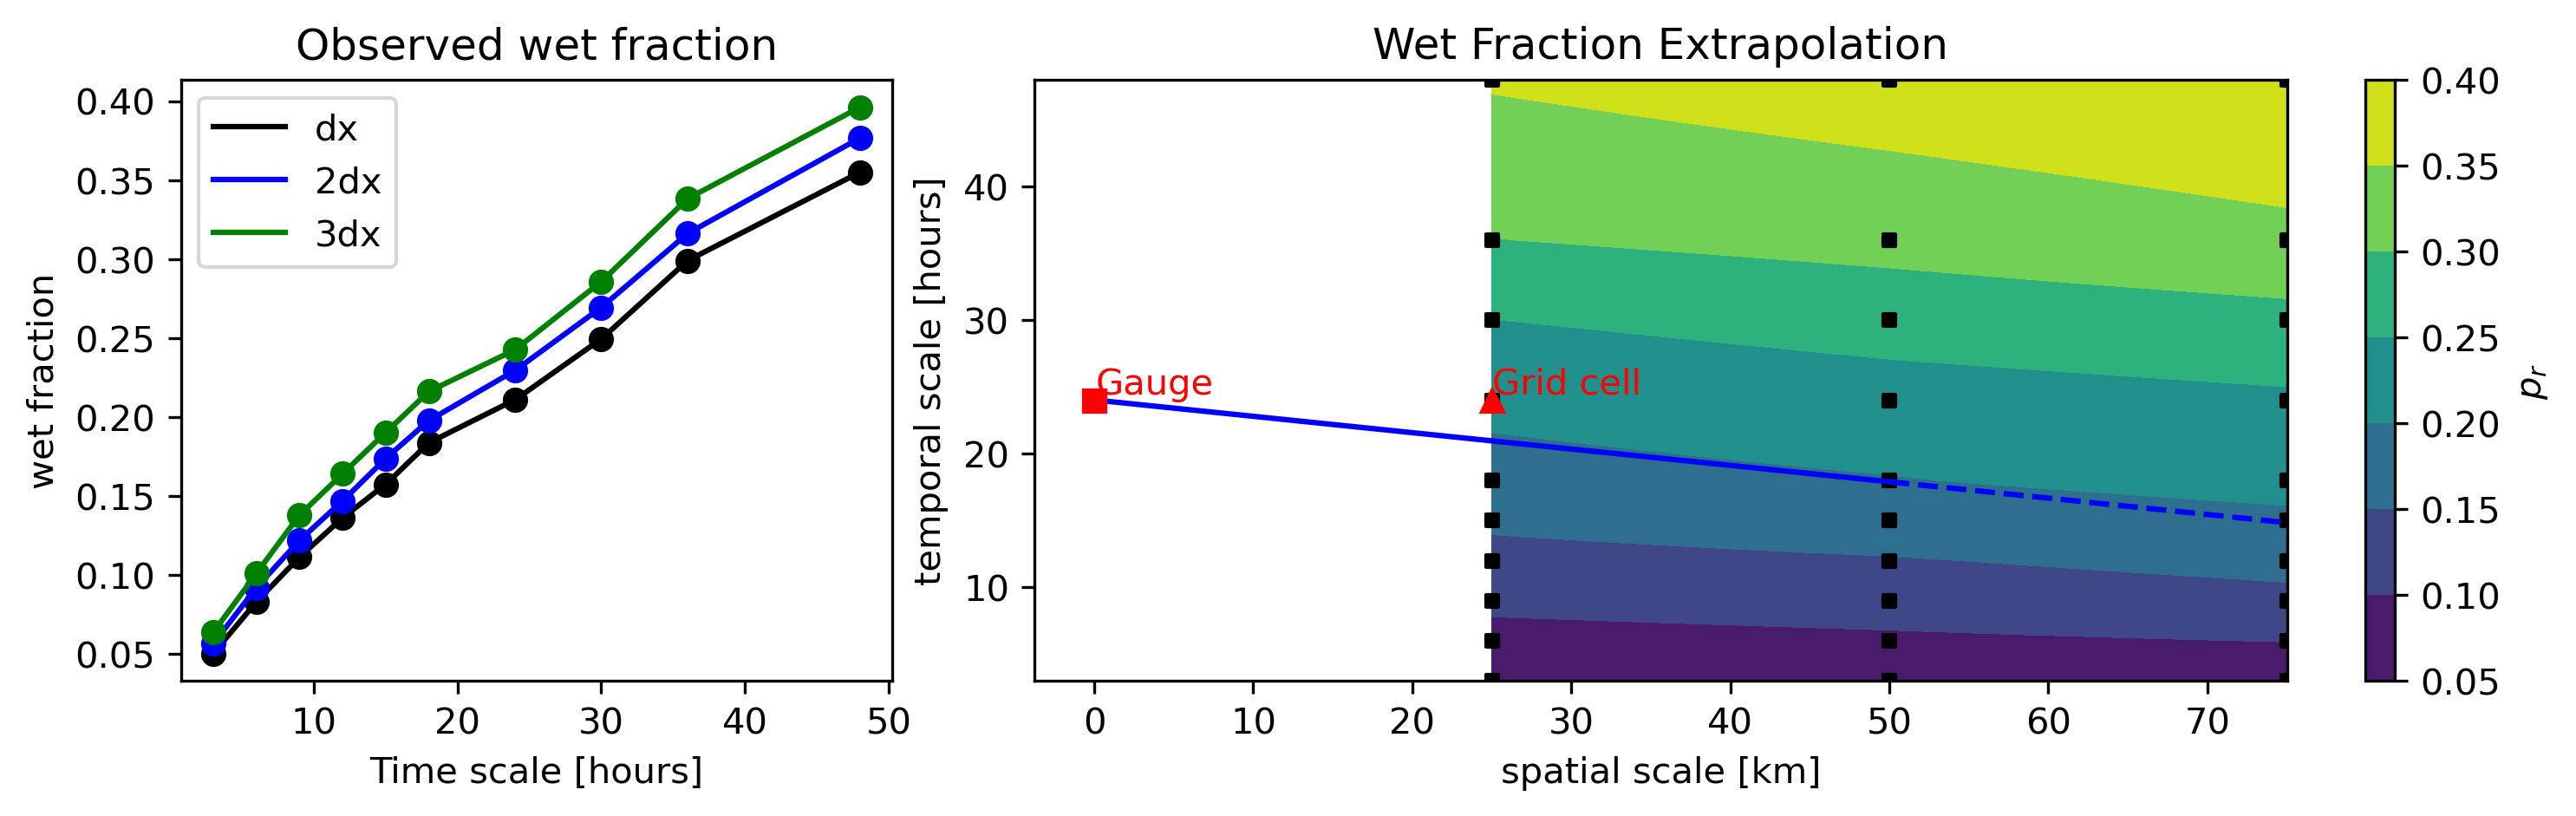

In [20]:
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(tscales, pwets[:,0], 'ok')
ax1.plot(tscales_int, pwmat_int[:,0], '-k', label = 'dx')

ax1.plot(tscales, pwets[:,1], 'ob')
ax1.plot(tscales_int, pwmat_int[:,1], '-b', label = '2dx')

if nxscales > 2:
    ax1.plot(tscales, pwets[:,2], 'og')
    ax1.plot(tscales_int, pwmat_int[:,2], '-g', label = '3dx')

ax1.set_xlabel('Time scale [hours]')
ax1.set_ylabel('wet fraction')
ax1.set_title('Observed wet fraction')
ax1.legend()

# =======================================================================================================
ax1 = plt.subplot(gs[0, 1:])
xxx1 = np.linspace(0, 50, 10)
xxx2 = np.linspace(50, 75, 10)
# PS3 = ax1.contourf(dxv, dtv, Nmatv)
PS3 = ax1.contourf(xscales_km, tscales_int, pwmat_int)

cbar = plt.colorbar(PS3)
cbar.set_label(r'$p_r$')

for ii in range(nxscales):
    for jj in range(ntscales):
        ax1.scatter(xscales_km[ii], tscales[jj], s=10, c='k', marker='s')
        
ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b')
ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b')
ax1.plot(target_x, target_t, 'sr')
ax1.plot(origin_x, origin_t, '^r')

ax1.text(0.1, 24.5, 'Gauge', color='red')
ax1.text(L1, 24.5, 'Grid cell', color='red')

ax1.set_xlabel('spatial scale [km]')
ax1.set_ylabel('temporal scale [hours]')
ax1.set_title('Wet Fraction Extrapolation')

In [21]:
xx = np.arange(2433)
# corrL = down.int_corr(xx, (resdown['eps_d'], resdown['alp_d']), acftype, 25.3)

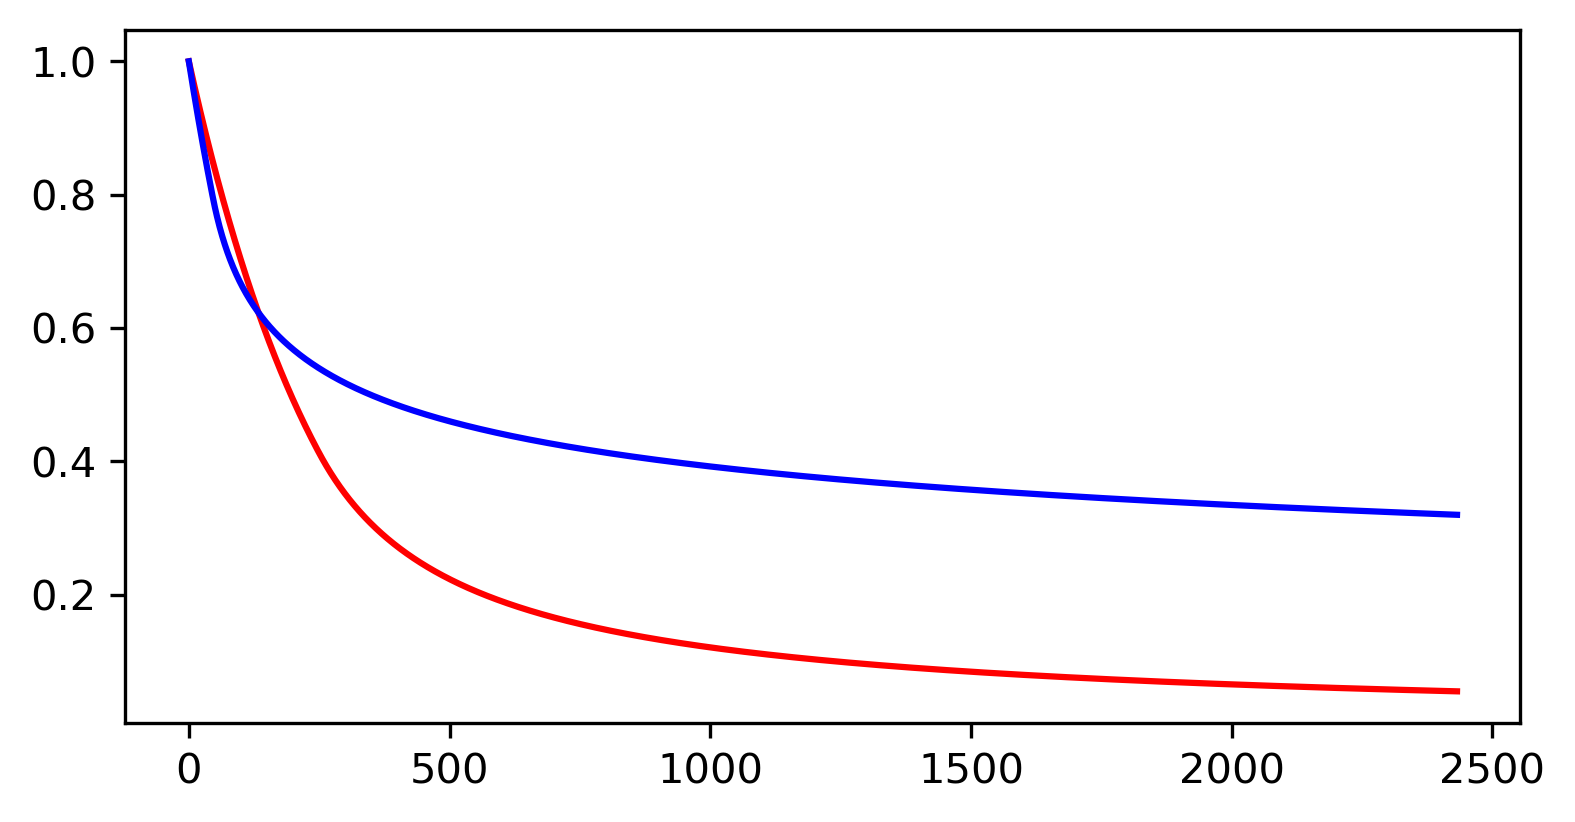

In [22]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(xx, down.epl_fun(xx, downres['eps_s'], downres['alp_s']), '-r')
ax1.plot(xx, down.epl_fun(xx, downres['eps_d'], downres['alp_d']), '-b')